In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
import os
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
np.random.seed(1)
tf.compat.v1.disable_v2_behavior() 
sns.set_theme(style="whitegrid")
if os.name == 'posix':
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt':
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import shap
import warnings
import time

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.expand_frame_repr',False)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#seoul_pow
#pusan_pow
#jeju_pow
#kor_dust -> 종로
#kangil_dust
#kangdong_dust
#incheon_dust


DATA_NAME = 'gwanak_dust'
MODEL_NAME = str(int(time.time()))
CLASSFICATION_EPOCH = 200
EPOCH = 30
FULLYCON = False
OTHER_FLAG = True


dataset = read_csv('./data/'+DATA_NAME+'.csv')
dataset_in = read_csv('./data/incheon_dust.csv')
dataset_kang = read_csv('./data/kangdong_dust.csv')

dataset_kang_t = dataset_in['PM25']
dataset_in_t = dataset_kang['PM25']

dataset.insert(loc=0, column='PM25_in', value=dataset_in_t)
dataset.insert(loc=0, column='PM25_kang', value=dataset_kang_t)

#dataset['Wy_PM_25'] = dataset['Wy']*dataset['PM25']*0.1
#dataset['Wx_PM_25'] = dataset['Wx']*dataset['PM25']*0.1

#dataset_gwan_T = np.roll(dataset['PM25'], -1)
#dataset.insert(loc=0, column='TARGET_t_'+str(-1), value=dataset_gwan_T)

#past_N = 8

#for i in range(past_N,past_N+1):
#    dataset_gwan_T = np.roll(dataset_gwan['PM25'], -i)
#    dataset.insert(loc=0, column='gwan_TARGET_t_'+str(i), value=dataset_gwan_T)

#for i in range(past_N,past_N+1):
#    dataset_kang_T = np.roll(dataset_kang['PM25'], -i)
#    dataset.insert(loc=0, column='kang_TARGET_t_'+str(i), value=dataset_kang_T)
    
#for i in range(1,past_N+1):
#    dataset_T = np.roll(dataset['Wy'], -i)
#    dataset.insert(loc=0, column='Wy_TARGET_t_'+str(i), value=dataset_T)
#    dataset_T = np.roll(dataset['Wx'], -i)
#    dataset.insert(loc=0, column='Wx_TARGET_t_'+str(i), value=dataset_T)


dataset_day = read_csv('./data/'+DATA_NAME+'_day.csv')

print('Data Cols / ',dataset.columns)


Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.


Data Cols /  Index(['PM25_kang', 'PM25_in', 'Unnamed: 0', '지역', '측정소코드', '측정소명', 'YMDH',
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', '주소', '망', 'fullday', 'month',
       'season', 'year', '지점', '지점명', '기온(°C)', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)',
       '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)',
       '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)', '지면상태(지면상태코드)',
       '현상번호(국내식)', '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
       '20cm 지중온도(°C)', '30cm 지중온도(°C)', 'Wx', 'Wy'],
      dtype='object')


(-8.5, 8.551202849151766, -7.7, 7.893418014601631)

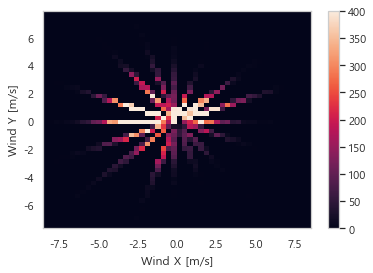

In [3]:
plt.hist2d(dataset['Wx'], dataset['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [4]:
'''
['Unnamed: 0', '지역', '측정소코드', '측정소명', 'YMDH', 'SO2', 'CO', 'O3', 'NO2',
'PM10', 'PM25', '주소', '망', 'fullday', 'month', 'season', 'year', '지점',
'지점명', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)',
'이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)',
'3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )',
'시정(10m)', '지면상태(지면상태코드)', '지면온도(°C)', '5cm 지중온도(°C)', 'Wx', 'Wy']

,'기온(°C)','강수량(mm)', '증기압(hPa)'

'''
Features = ['PM25','PM25_in','PM25_kang', 'Wx', 'Wy','SO2', 'CO', 'NO2','PM10']
Target = 'PM25'

               PM25       PM25_in     PM25_kang            Wx            Wy           SO2            CO           NO2          PM10
count  51144.000000  51144.000000  51144.000000  51144.000000  5.114400e+04  51144.000000  51144.000000  51144.000000  51144.000000
mean      24.800328     23.523463     23.263237     -0.658101  2.933870e-01      0.004558      0.504853      0.031190     42.924292
std       18.259230     17.158137     17.614513      1.942010  1.284574e+00      0.002102      0.274024      0.018287     31.517509
min        0.000000      0.000000      0.000000     -8.500000 -7.700000e+00      0.000000      0.000000      0.000000      0.000000
25%       13.000000     12.000000     12.000000     -2.000000 -6.062002e-16      0.003000      0.300000      0.018000     25.000000
50%       21.000000     20.000000     20.000000     -0.578509  2.736161e-01      0.004000      0.400000      0.027000     38.000000
75%       33.000000     31.000000     32.000000      0.536231  9.918584e-01 

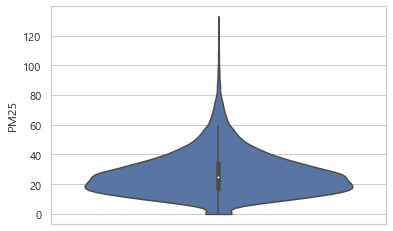

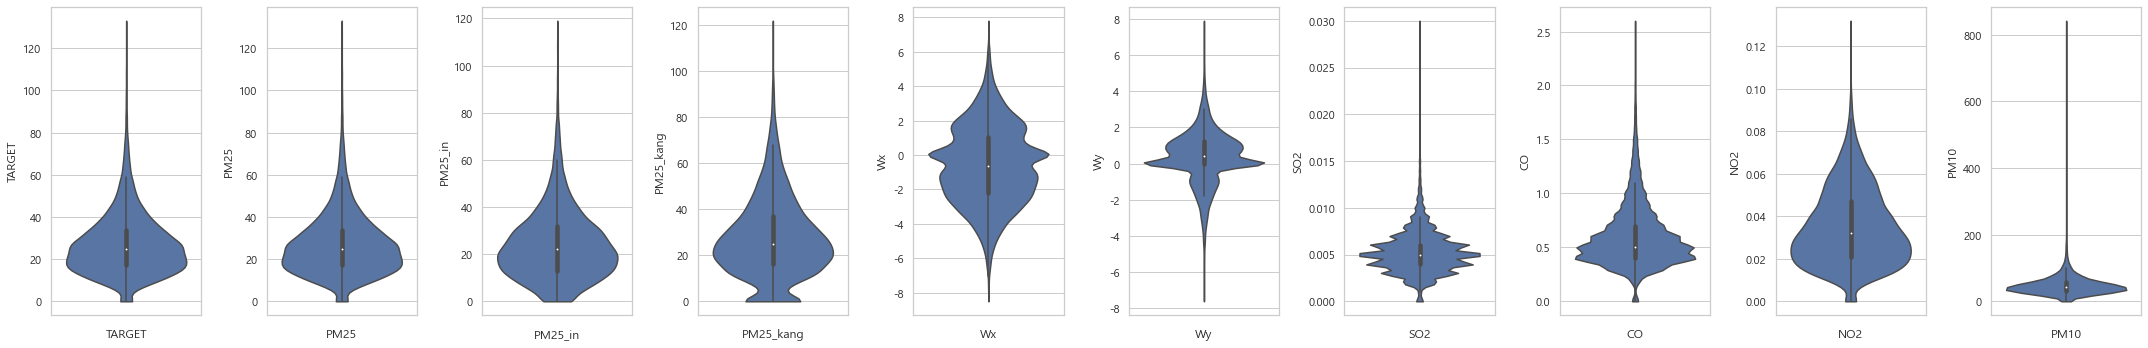

TARGET      PM25   PM25_in  PM25_kang        Wx        Wy       SO2        CO       NO2      PM10
TARGET     1.000000  0.601977  0.546418   0.478258 -0.146241 -0.138762  0.312190  0.304573  0.235421  0.473175
PM25       0.601977  1.000000  0.762554   0.669331 -0.114322 -0.087557  0.416048  0.503448  0.364924  0.723780
PM25_in    0.546418  0.762554  1.000000   0.654066 -0.113273 -0.071154  0.433774  0.482675  0.332050  0.564458
PM25_kang  0.478258  0.669331  0.654066   1.000000 -0.000558 -0.041656  0.380228  0.528073  0.346473  0.544855
Wx        -0.146241 -0.114322 -0.113273  -0.000558  1.000000  0.209010 -0.216847  0.142860  0.199964 -0.151208
Wy        -0.138762 -0.087557 -0.071154  -0.041656  0.209010  1.000000 -0.104048  0.031030  0.047424 -0.058465
SO2        0.312190  0.416048  0.433774   0.380228 -0.216847 -0.104048  1.000000  0.370730  0.308610  0.318017
CO         0.304573  0.503448  0.482675   0.528073  0.142860  0.031030  0.370730  1.000000  0.752381  0.381947
NO2        0.235421  0.364924  0.332050   0.346473  0.199964  0.047424  0.308610  0.752381  1.000000  0.252151
PM10       0.473175  0.723780  0.564458   0.544855 -0.151208 -0.058465  0.318017  0.381947  0.252151  1.000000

In [5]:


#Features = ['SO2', 'CO', 'O3','NO2', 'PM10', 'PM25']
#Target = 'PM25'

#Features.append('fullday')
#Features.append('YMDH')

print(dataset[Features].describe())

DF=dataset[:24*730]


TEST=DF[Features]
TEST_T = DF[Target]
TEST_T = np.roll(TEST_T,-8)
TEST.insert(loc=0, column='TARGET', value=TEST_T)

#TEST = pd.concat([TEST_T,TEST], axis=1)

#TEST_DAY = dataset_day[Features]
Target_LIST = list(TEST_T)

sns.violinplot(y=DF[Target],cut=0)
TMP = TEST.select_dtypes(exclude=['object'])

'''
SCALED_Y = DF[[Target]].values.astype(float)
Y_min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
Target_LIST = Y_min_max_scaler.fit_transform(Target_LIST)
Target_LIST = list(Target_LIST)
'''


fig = plt.figure(figsize=(3*len(TMP.columns),5))
gs = fig.add_gridspec(1, len(TMP.columns))

for i in range(len(TMP.columns)):
    ax = fig.add_subplot(gs[0, i])
    print(TMP.columns[i])
    sns.violinplot(y=TMP[TMP.columns[i]],cut=0)
    ax.set_xlabel(TMP.columns[i])

fig.tight_layout()
plt.show()

TMP.corr()

In [6]:


#['전력거래량','풍속(m/s)', '습도(%)','일사(MJ/m2)','지면온도(°C)','일조(hr)', '해면기압(hPa)']
#이하, 초과 [MAX, MIN]

#    '0': {
#        '기온(°C)': [[1.00, .75]],'강수량(mm)': [[1.00, .75]]
#    }, 
#['SO2', 'CO', 'O3','NO2', 'PM10', 'PM25']
'''
FeaturesRange = {
    '0': {
        'PM10': [[1.00, 0.25]]
    }, 
    '1': {
        'PM10': [[0.25, 0.20]]
    } 
}

FeaturesRange = {
    '0': {
        'Ground temperature': [[1.0, 0.75]]
    },
    '1': {
        'Ground temperature': [[0.75, 0.5]]
    },
    '2': {
        'Ground temperature': [[0.5, 0.25]]
    },
    '3': {
        'Ground temperature': [[0.25, -0.01]]
    }
}
'''
FeaturesRange = {
    '0': {
        'Wx': [[float("inf"), 0.0]]
    },
}


In [7]:

def GetSubSets(_DF,_dataset_day,FeaturesRange):
    
    full_df = _DF
    full_df['Group'] = 'Other'
    

    res_GDF = []
    GroupDF = {}
    
    for Groups in FeaturesRange:
        TMP = FeaturesRange[Groups]
        GroupDF[Groups] = full_df
        for Feature in TMP:
            Filters = TMP[Feature]
            for MAX,MIN in Filters:
                GroupDF[Groups] = GroupDF[Groups].loc[(GroupDF[Groups][Feature] > MIN) & (GroupDF[Groups][Feature] <= MAX)]

    for Groups in GroupDF:
        GroupDF[Groups]['Group'] = Groups
        print(GroupDF[Groups].size)
        res_GDF.append(GroupDF[Groups])
        full_df = full_df.drop(GroupDF[Groups].index, errors='ignore')
    
    full_df=full_df.dropna(axis=0)
    
    if not full_df.empty:
        res_GDF.append(full_df)
    else:
        print('OTHER_FLAG')
        OTHER_FLAG=False
    return res_GDF


In [8]:
RES_TEST = GetSubSets(TEST,dataset_day,FeaturesRange)
for Q in RES_TEST:
    print(Q.groupby('Group').count())


if len(RES_TEST)==len(FeaturesRange):
    OTHER_FLAG = False 

print(OTHER_FLAG)

#Features.remove('fullday')
#Features.remove('YMDH')


70279
       TARGET  PM25  PM25_in  PM25_kang    Wx    Wy   SO2    CO   NO2  PM10
Group                                                                      
0        6389  6389     6389       6389  6389  6389  6389  6389  6389  6389
       TARGET   PM25  PM25_in  PM25_kang     Wx     Wy    SO2     CO    NO2   PM10
Group                                                                             
Other   11131  11131    11131      11131  11131  11131  11131  11131  11131  11131
True



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:

#'MINMAX'
#'STD'
#'YEO'
# ''
SCALE_FUNC = 'STD'

def SCALE_FUCTIONS(_DF):
    TMP_TARGET = _DF['TARGET'].to_list()
    
    _DF=_DF[Features]
    if SCALE_FUNC == 'MINMAX':
        _DF = MINMAX_scaler.transform(_DF)
    elif SCALE_FUNC == 'STD':
        _DF = STD_scaler.transform(_DF.values)
    elif SCALE_FUNC == 'YEO':
        _DF = YEO_scaler.transform(_DF)
    else:
        _DF = _DF
    
    _DF = pd.DataFrame(_DF,columns=Features)
    _DF.insert(loc=0, column='TARGET', value=TMP_TARGET)
    return _DF
    
MINMAX_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
STD_scaler = preprocessing.StandardScaler()
YEO_scaler = preprocessing.PowerTransformer(method='yeo-johnson')

Y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

TEST = DF[Features]
MINMAX_scaler.fit(TEST)
STD_scaler.fit(TEST)
YEO_scaler.fit(TEST)

Y_scaler.fit(np.array(Target_LIST).reshape(-1,1))

ALL_X=DF[Features]
print(ALL_X)
ALL_X.insert(loc=0, column='TARGET', value=Target_LIST)
ALL_X=ALL_X.dropna(axis=0)
ALL_X.reset_index(inplace=True, drop=True)
ALL_X = SCALE_FUCTIONS(ALL_X)


for i in range(len(RES_TEST)):
    RES_TEST[i] = SCALE_FUCTIONS(RES_TEST[i])
    

       PM25  PM25_in  PM25_kang        Wx        Wy    SO2   CO    NO2   PM10
0      11.0      6.0       21.0 -4.416555  1.607495  0.005  0.4  0.012   50.0
1      12.0      8.0       17.0 -4.228617  1.539091  0.006  0.4  0.011   62.0
2      12.0      8.0       17.0 -3.570832  1.299677  0.006  0.5  0.012   77.0
3      11.0      7.0       24.0 -4.604494  1.675899  0.005  0.4  0.008   89.0
4      15.0     10.0       20.0 -5.356248  1.949515  0.005  0.4  0.008  100.0
...     ...      ...        ...       ...       ...    ...  ...    ...    ...
17515  42.0     34.0       49.0  0.239414  0.657785  0.009  1.5  0.079   55.0
17516  45.0     33.0       47.0  0.444626  1.221600  0.009  1.6  0.079   62.0
17517  35.0     33.0       45.0  0.649838  1.785416  0.008  1.3  0.078   48.0
17518  39.0     35.0       48.0  0.444626  1.221600  0.008  1.5  0.088   55.0
17519  37.0     29.0       65.0  0.000000  0.000000  0.008  1.4  0.087   48.0

[17520 rows x 9 columns]


In [10]:
ALL_X

TARGET      PM25   PM25_in  PM25_kang        Wx        Wy       SO2        CO       NO2      PM10
0        12.0 -1.068597 -1.207061  -0.380372 -1.687490  0.863604 -0.114733 -0.710006 -1.268572  0.043053
1        11.0 -1.002128 -1.072911  -0.606025 -1.604932  0.816228  0.324542 -0.710006 -1.324024  0.379710
2         8.0 -1.002128 -1.072911  -0.606025 -1.315981  0.650412  0.324542 -0.365264 -1.268572  0.800532
3        11.0 -1.068597 -1.139986  -0.211131 -1.770048  0.910980 -0.114733 -0.710006 -1.490382  1.137189
4         5.0 -0.802723 -0.938760  -0.436785 -2.100279  1.100484 -0.114733 -0.710006 -1.490382  1.445792
...       ...       ...       ...        ...       ...       ...       ...       ...       ...       ...
17515    11.0  0.991923  0.671042   1.199202  0.357785  0.205844  1.642367  3.082149  2.446748  0.183327
17516    15.0  1.191328  0.603967   1.086376  0.447931  0.596337  1.642367  3.426891  2.446748  0.379710
17517    13.0  0.526644  0.603967   0.973549  0.538076  0.986830  1.203092  2.392666  2.391296 -0.013057
17518    13.0  0.792518  0.738117   1.142789  0.447931  0.596337  1.203092  3.082149  2.945821  0.183327
17519    12.0  0.659581  0.335666   2.101816  0.252615 -0.249731  1.203092  2.737408  2.890368 -0.013057

[17520 rows x 10 columns]

In [11]:
G_TRAIN_X = []
G_TRAIN_y = []

G_TEST_X = []
G_TEST_y = []

G_DISPLAY_Y = []
G_DISPLAY_TEST_Y = []
MIN_Y=float("inf")
MAX_Y=-1
for G in RES_TEST:
    values = G.values
    Xdata = values[:, 1:]
    Xdata = Xdata.reshape((int(Xdata.shape[0]),1,len(Features)))
    
    G_TRAIN_X.append(Xdata[:int(Xdata.shape[0]*0.8)])
    G_TEST_X.append(Xdata[int(Xdata.shape[0]*0.8):])
    
    Ydata = values[:, 0]
    Ydata = Ydata.reshape((int(len(Ydata)),1))
    
    Ydata = Ydata.sum(axis=1)
    Ydata = list(Ydata.reshape((Ydata.shape[0],)))
    if MIN_Y>min(Ydata):
        MIN_Y = min(Ydata)
    if MAX_Y<max(Ydata):
        MAX_Y = max(Ydata)
    
    G_DISPLAY_Y = G_DISPLAY_Y+Ydata[:int(len(Ydata)*0.8)]
    G_DISPLAY_TEST_Y= G_DISPLAY_TEST_Y + Ydata[int(len(Ydata)*0.8):]
    
    if FULLYCON:
        Ydata = Ydataa.reshape((Ydata.shape[0],Ydata.shape[1],1))

    G_TRAIN_y.append(Ydata[:int(len(Ydata)*0.8)])
    G_TEST_y.append(Ydata[int(len(Ydata)*0.8):])



CLASSIFI_TEST_X = G_TEST_X[0]
CLASSIFI_TEST_y = [0 for _ in range(G_TEST_X[0].shape[0])]

for G in range(1,len(RES_TEST)):
    CLASSIFI_TEST_X = np.concatenate((CLASSIFI_TEST_X, G_TEST_X[G]), axis=0)
    CLASSIFI_TEST_y = CLASSIFI_TEST_y + [G for _ in range(G_TEST_X[G].shape[0])]

CLASSIFI_TEST_X = CLASSIFI_TEST_X.reshape((CLASSIFI_TEST_X.shape[0],CLASSIFI_TEST_X.shape[1]*CLASSIFI_TEST_X.shape[2]))



CLASSIFI_TEST_y
CLASSIFI_TEST_y = np.array(CLASSIFI_TEST_y)
CLASSIFI_TEST_y_Dis = CLASSIFI_TEST_y
CLASSIFI_TEST_y = pd.get_dummies(CLASSIFI_TEST_y)

for i in range(len(G_TRAIN_y)):
    G_TRAIN_y[i] = list(Y_scaler.transform(np.array(G_TRAIN_y[i]).reshape(-1,1)).flatten())


In [12]:

values = ALL_X.values
Xdata = values[:, 1:]
Xdata = Xdata.reshape((int(Xdata.shape[0]),1,len(Features)))
    
ALL_TRAIN_X=Xdata[:int(Xdata.shape[0]*0.8)]
    
Ydata = values[:, 0]
Ydata = Ydata.reshape((int(len(Ydata)),1))
    
Ydata = Ydata.sum(axis=1)
Ydata = list(Ydata.reshape((Ydata.shape[0],)))

ALL_DISPLAY_Y = []

ALL_DISPLAY_Y = ALL_DISPLAY_Y+Ydata[:int(len(Ydata)*0.8)]
    
ALL_TRAIN_y = Ydata[:int(len(Ydata)*0.8)]

ALL_TRAIN_y = list(Y_scaler.transform(np.array(ALL_TRAIN_y).reshape(-1,1)).flatten())


In [13]:
#CLASSFICATION_PATH = MODEL_PATH+'/'+MODEL_NAME+'_CLASSIFICATION.h5'

import random

testlinC = []
for i in range(100):
    testlinC.append(random.randint(0, CLASSIFI_TEST_X.shape[0]-1))

enTest_X = CLASSIFI_TEST_X[testlinC, :]
enTest_y = CLASSIFI_TEST_y_Dis[testlinC]

enTest_dis_y= G_DISPLAY_TEST_Y[:]
enTest_dis_y = np.vstack(enTest_dis_y)
enTest_dis_y = enTest_dis_y[testlinC,:]

print(enTest_dis_y.shape)

print(enTest_X.shape)

(100, 1)
(100, 9)


In [14]:
MODEL_PATH ='models/'+DATA_NAME+'/'+MODEL_NAME 
os.makedirs(MODEL_PATH, exist_ok=True)

tp = pd.DataFrame( data = {'MIN_Y': [MIN_Y],'MAX_Y': [MAX_Y] } )
tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_MINMAX.csv')

weights_dict = [dict() for _ in range(len(RES_TEST))]
def TEMPFUNC(TI):
    return models[TI].predict(G_TRAIN_X[TI])

def build_model(train_X, train_y ):
    M = tf.keras.Sequential()

    if FULLYCON:
        M.add(tf.keras.layers.LSTM(200,  input_shape = (train_X.shape[1], train_X.shape[2])))
        M.add(tf.keras.layers.RepeatVector(24))
        M.add(tf.keras.layers.LSTM(200,  return_sequences=True))
        M.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
        M.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
    else:
        M.add(tf.keras.layers.LSTM(100,  input_shape = (train_X.shape[1], train_X.shape[2])))
        M.add(tf.keras.layers.Dense(50, activation='relu'))
        M.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam()

    M.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_logarithmic_error','mean_squared_error'])
    return M


#mean_absolute_error

models = []
for GN in range(len(RES_TEST)):
    models.append(build_model(G_TRAIN_X[GN],G_TRAIN_y[GN]))
        # Open the file
    with open(MODEL_PATH + '/'+str(GN)+'_summary.txt','w') as fh:
        models[GN].summary(print_fn=lambda x: fh.write(x + '\n'))

ALL_MODEL = build_model(ALL_TRAIN_X,ALL_TRAIN_y)
ALL_MODEL.fit(ALL_TRAIN_X, ALL_TRAIN_y, epochs=EPOCH, verbose=1, shuffle=False)

for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
        
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    os.makedirs(_path, exist_ok=True)
    weight_callback = tf.keras.callbacks.LambdaCallback( on_epoch_end=lambda epoch, logs: weights_dict[GN].update({epoch:TEMPFUNC(GN)}))
    csv_logger = tf.keras.callbacks.CSVLogger(_path+'/'+DATA_NAME+'_G_'+GNAME+'_epoch'+'.csv', separator=',')
    
    models[GN].fit(G_TRAIN_X[GN], G_TRAIN_y[GN], epochs=EPOCH, verbose=1, shuffle=False, callbacks=[weight_callback,csv_logger] )

    BIAS_DEF = []
    VAR_DEF = []
    for T in weights_dict[GN]:
        YT = weights_dict[GN][T]
        YT_var = [np.mean(x) for x in YT]
        var = [pow(np.mean(x)-np.mean(YT_var),2) for x in YT]
        bias = []
        for Gi in range(0,len(G_TRAIN_y[GN])):
            bias.append(pow(np.mean(G_TRAIN_y[GN][Gi]) - YT[Gi],2))
        VAR_DEF.append(np.mean(var))
        BIAS_DEF.append(np.mean(bias))
    BV = pd.DataFrame( data = {'BIAS': BIAS_DEF, 'VAR': VAR_DEF} )
    
    models[GN].save(_path+'/'+DATA_NAME+'_G_'+GNAME+'.h5')
    BV.to_csv(_path+'/'+DATA_NAME+'_G_'+GNAME+'_BIAS_VAR'+'.csv', index=False) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 14016 samples
Epoch 1/30
14016/14016 [==============================] - 0s 26us/sample - loss: 0.0094 - mean_squared_logarithmic_error: 0.0059 - mean_squared_error: 0.0094
Epoch 2/30
14016/14016 [==============================] - 0s 26us/sample - loss: 0.0086 - mean_squared_logarithmic_error: 0.0054 - mean_squared_error: 0.0086
Epoch 3/30
14016/14016 [==============================] - 0s 26us/sample - loss: 0.0082 - mean_squared_logarithmic_error: 0.0052 - mean_squared_error: 0.0082
Epoch 4/30
14016/14016 [==============================] - 0s 26us/sample - loss: 0.0080 - mean_squared_logarithmic_error: 0.0051 - mean_squared_error: 0.0080
Epoch 5/30
14016/14016 [==============================] - 0s 26us/sample - loss: 0.0080 - mean_squared_logarithmic_error: 0.0050 - mean_squared_error: 0.0080
Epoch 6/30
14016/14016 [==============================] - 0s 26us/sample - loss: 0.0079 - mean_squared_log

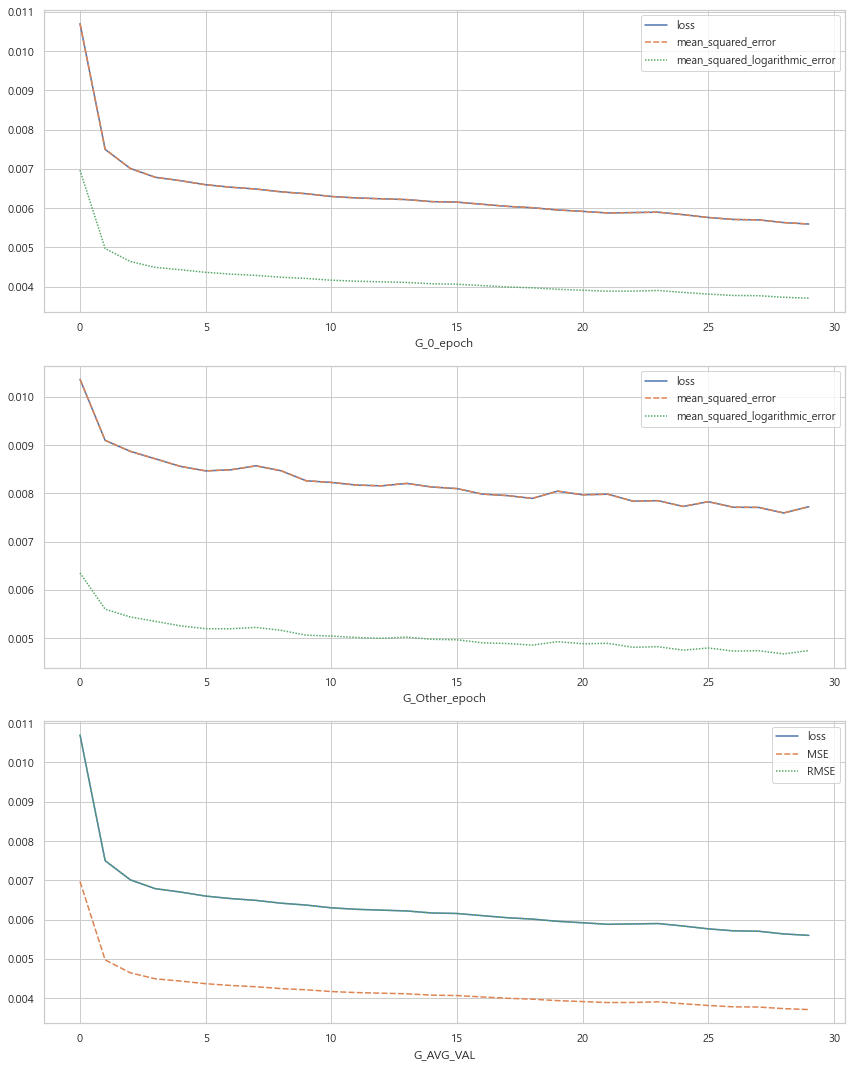

In [15]:
fig = plt.figure(figsize=(12,5*(len(models)+1)))
gs = fig.add_gridspec( (len(models)+1),1)

MSE = []
MAE = []
RMSE = []

for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    TDF = read_csv(_path+'/'+DATA_NAME+'_G_'+GNAME+'_epoch'+'.csv')
    ax = fig.add_subplot(gs[GN, 0])
    sns.lineplot(data=TDF[TDF.columns.difference(['epoch'])], legend=True)
    ax.set_xlabel('G_'+GNAME+'_epoch')
    if GN != len(models)-1:
        MAE.append(TDF['loss'].to_list())
        MSE.append(TDF['mean_squared_logarithmic_error'].to_list())
        RMSE.append(TDF['mean_squared_error'].to_list())
        
MSE = np.array(MSE)
MAE = np.array(MAE)
RMSE = np.array(RMSE)

BV = pd.DataFrame( data = {'loss': MAE.mean(axis=0), 'MSE': MSE.mean(axis=0), 'RMSE':RMSE.mean(axis=0)} )
BV.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_loss.csv', index=False)
ax = fig.add_subplot(gs[GN+1, 0])
sns.lineplot(data=BV, legend=True)
ax.set_xlabel('G_AVG_VAL')

fig.tight_layout()
plt.savefig(MODEL_PATH+'/Models_LOSS.png')
plt.show()

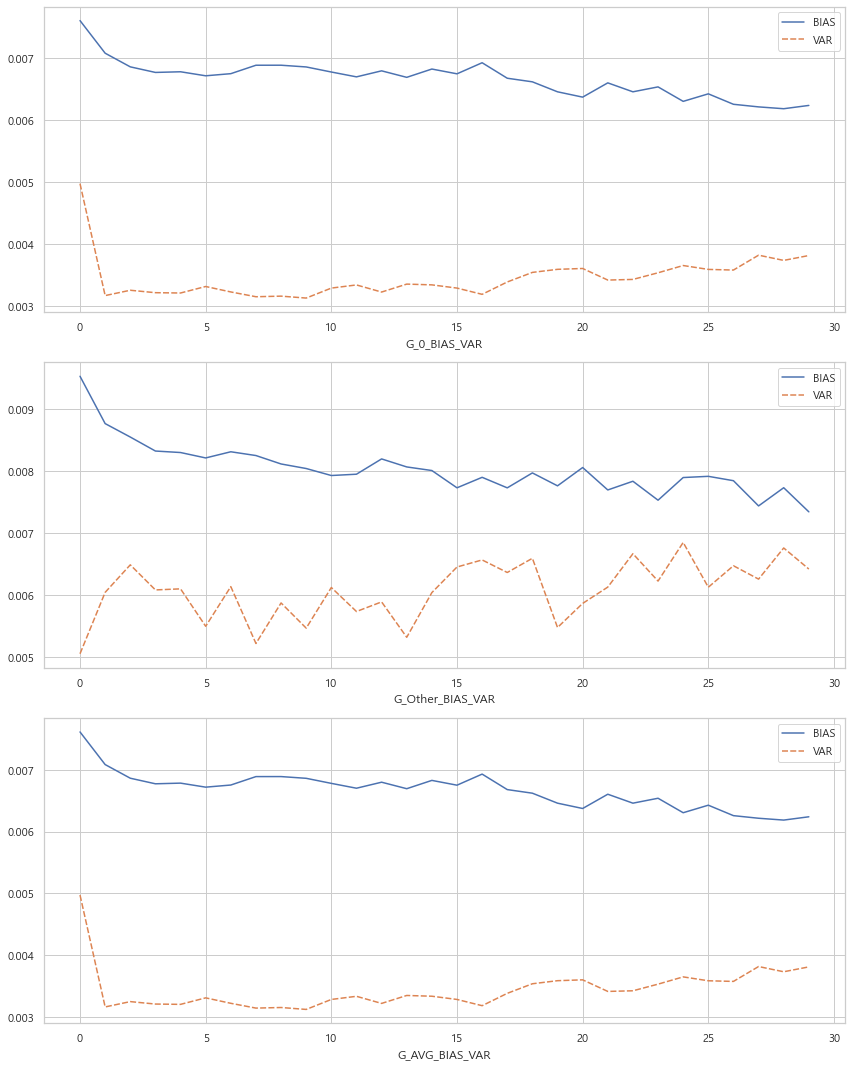

In [16]:
fig = plt.figure(figsize=(12,5*(len(models)+1)))
gs = fig.add_gridspec( (len(models)+1),1)

BIAS = []
VAR = []

for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    TDF = read_csv(_path+'/'+DATA_NAME+'_G_'+GNAME+'_BIAS_VAR'+'.csv')
    ax = fig.add_subplot(gs[GN, 0])
    sns.lineplot(data=TDF, legend=True)
    if GN != len(models)-1:
        BIAS.append(TDF['BIAS'].to_list())
        VAR.append(TDF['VAR'].to_list())

    ax.set_xlabel('G_'+GNAME+'_BIAS_VAR')
BIAS = np.array(BIAS)
VAR = np.array(VAR)

BV = pd.DataFrame( data = {'BIAS': BIAS.mean(axis=0), 'VAR': VAR.mean(axis=0)} )

ax = fig.add_subplot(gs[GN+1, 0])
sns.lineplot(data=BV, legend=True)
ax.set_xlabel('G_AVG_BIAS_VAR')

fig.tight_layout()
plt.savefig(MODEL_PATH+'/Models_BIAS_VAR.png')
plt.show()
    

In [17]:
ENS_MODELS = []
for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    ENS_MODELS.append(tf.keras.models.load_model(_path+'/'+DATA_NAME+'_G_'+GNAME+'.h5'))

#_path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_All'
#ALL_MODELS = tf.keras.models.load_model(_path+'/'+DATA_NAME+'_G_All.h5')
#MD = tf.keras.models.load_model(CLASSFICATION_PATH)

#class_yhat = MD.predict(enTest_X)

enTest_reg_X = enTest_X.reshape((enTest_X.shape[0],1,len(Features)))

ALL_Y_HAT = ALL_MODEL.predict(enTest_reg_X)

ENS_Y_HATS = []

for M in ENS_MODELS:
    ENS_Y_HATS.append(M.predict(enTest_reg_X))


#CLASS_X = np.reshape(CLASS_X,(1,72))
#CLASS_X.shape


print(len(ENS_Y_HATS))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2


In [18]:
Weighted = np.zeros((enTest_reg_X.shape[0],(len(models)) if OTHER_FLAG else (len(models))), dtype=int)

for i in range(enTest_reg_X.shape[0]):
    for Key in FeaturesRange:
        for FILTERS in FeaturesRange[Key]:
            FT = FeaturesRange[Key][FILTERS][0]
            tempMEAN = enTest_reg_X[i].mean(axis=0)
            if tempMEAN[Features.index(FILTERS)]<=FT[0] and tempMEAN[Features.index(FILTERS)]>FT[1]:
                Weighted[i][int(Key)] = 1
    if sum(Weighted[i])==0:
        Weighted[i][-1]=1            
Weighted

array([[1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1,

(100,)
(100,)
(100,)


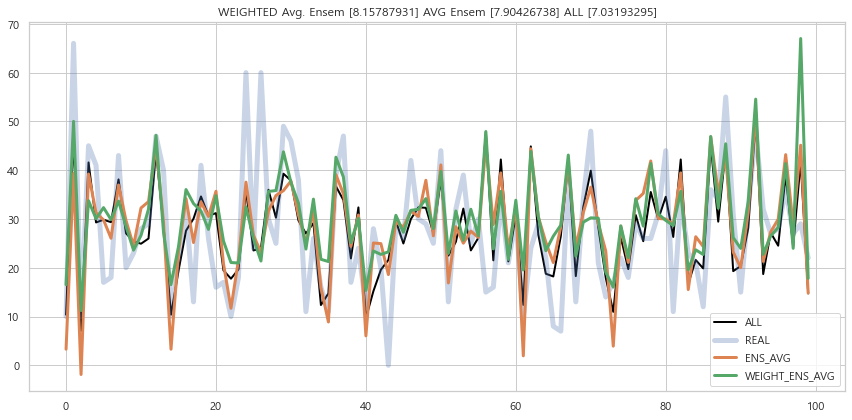

In [19]:
TEST_NUM = 50
WEIGHT_ENS_RESULT = []
ENS_RESULT = []
ALL_RESULT = list(Y_scaler.inverse_transform(np.array(ALL_Y_HAT).reshape(-1,1)).flatten())

ALL_RESULT = np.array(ALL_RESULT)
ALL_RESULT = ALL_RESULT.reshape((int(len(ENS_Y_HATS[0])),))



tmp_ENS_HATS = []
    
    
for i in range(len(ENS_Y_HATS)):
    tmp_ENS_HATS.append(list(Y_scaler.inverse_transform(np.array(ENS_Y_HATS[i]).reshape(-1,1)).flatten()))


for i in range(len(tmp_ENS_HATS[0])):
    tmpWER = 0
    for idx in range(len(tmp_ENS_HATS)):
        tmpWER+= tmp_ENS_HATS[idx][i]*Weighted[i][idx]
        ENS_RESULT.append(tmp_ENS_HATS[idx][i])
    
    WEIGHT_ENS_RESULT.append(tmpWER/(sum(Weighted[i])))

WEIGHT_ENS_RESULT = np.array(WEIGHT_ENS_RESULT)

WEIGHT_ENS_RESULT = WEIGHT_ENS_RESULT.reshape((int(len(ENS_Y_HATS[0])),))
#WEIGHT_ENS_RESULT = WEIGHT_ENS_RESULT.sum(axis=1)/
print(WEIGHT_ENS_RESULT.shape)

ENS_RESULT = np.array(ENS_RESULT)
ENS_RESULT = ENS_RESULT.reshape((int(len(ENS_Y_HATS[0])),len(ENS_Y_HATS)))
ENS_RESULT = ENS_RESULT.mean(axis=1)
print(ENS_RESULT.shape)
print(ALL_RESULT.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# create data
x = [x for x in range(len(ENS_Y_HATS[0]))]
WER = []
ER = []
AR = []
for i in range(len(enTest_dis_y)):
    WER.append(abs(WEIGHT_ENS_RESULT[i]-enTest_dis_y[i]))
    ER.append(abs(ENS_RESULT[i]-enTest_dis_y[i]))
    AR.append(abs(ALL_RESULT[i]-enTest_dis_y[i]))

plt.title('WEIGHTED Avg. Ensem '+str(sum(WER)/len(WER))+' AVG Ensem '+str(sum(ER)/len(ER))+' ALL '+str(sum(AR)/len(AR)))

plt.plot(x, ALL_RESULT, label = "ALL", color="black", linewidth=2, alpha=1)

plt.plot(x, enTest_dis_y, label = "REAL" , linewidth=5, alpha=0.3)
plt.plot(x, ENS_RESULT, label = "ENS_AVG", linewidth=3, alpha=1)
plt.plot(x, WEIGHT_ENS_RESULT, label = "WEIGHT_ENS_AVG", linewidth=3, alpha=1)
plt.legend()

plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_Line_Chart.png')
plt.show()



In [20]:

#sum_1 = np.sum(shap_val,axis=1)
import json
with open(MODEL_PATH+'/'+MODEL_NAME+'_FEAT_RANGE.json', "w", encoding='utf8') as outfile: 
    json.dump(FeaturesRange, outfile, ensure_ascii=False)

tp = pd.DataFrame( data = {'Features': Features } )
tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_Features.csv')

tp = pd.DataFrame(data = {'TEST_idx': testlinC })
tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_TEST_idx.csv')




In [26]:





explainer_list = []
expected_value_list = []
shap_values_list = []

for i in range(len(ENS_MODELS)):
    GNAME = str(i)
    if i == len(ENS_MODELS)-1 and OTHER_FLAG:
        GNAME = 'Other'
    print(str(i)+' 모델 shap 계산중.')
    explainer = shap.DeepExplainer(ENS_MODELS[i], G_TRAIN_X[i])
    expected_value = explainer.expected_value[0]
    shap_values = explainer.shap_values(G_TRAIN_X[i][:100])
    shap_val = shap_values[0]
    SH_NP = np.array(shap_val)
    SH_NP = SH_NP.reshape((SH_NP.shape[0]*SH_NP.shape[1],SH_NP.shape[2]))
    tp = pd.DataFrame(SH_NP, columns=Features)
    tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_SHAP_G_'+GNAME+'.csv')

    
    tp = pd.DataFrame( data = {'expected_value': [expected_value] } )
    tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_SHAP_EXP'+GNAME+'.csv')
    
    explainer_list.append(explainer)
    expected_value_list.append(expected_value)
    shap_values_list.append(SH_NP)




0 모델 shap 계산중.
1 모델 shap 계산중.


In [27]:
shap_val.shape

(100, 1, 9)

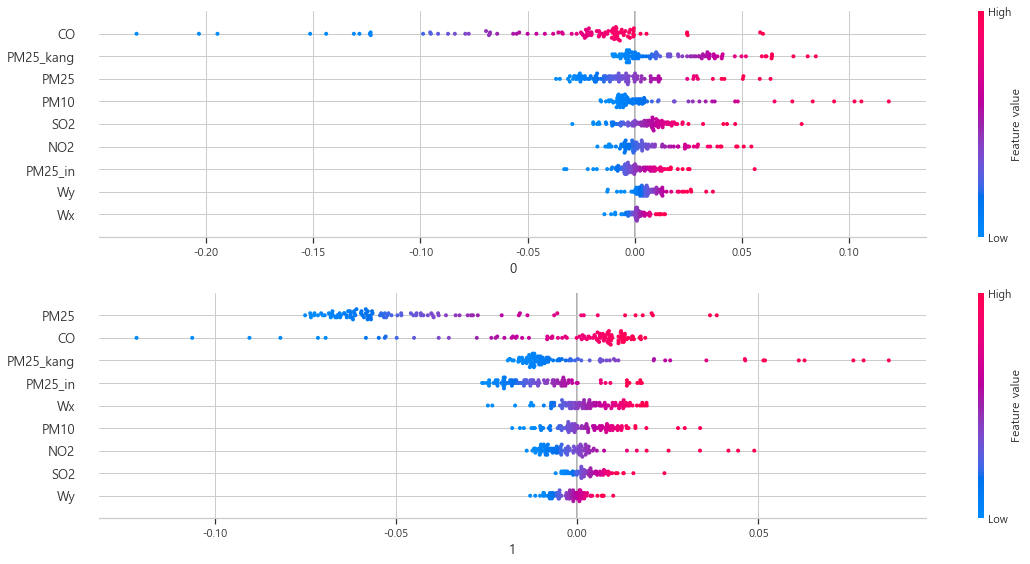

[array([[-1.57804745e-02, -3.39346600e-03, -3.46248426e-03,
          1.74907728e-03,  5.19550386e-03,  1.29473111e-02,
         -9.62932559e-03,  1.44929653e-03, -4.15200672e-03],
        [-3.03652576e-02, -2.66748824e-03, -1.36520756e-03,
          1.04986802e-03,  5.01933199e-03,  1.55637690e-02,
         -1.38424625e-02,  7.45537923e-03,  2.71247414e-03],
        [-1.71013436e-02,  4.58739973e-03,  5.32774565e-03,
          7.25479842e-04,  5.24272760e-03,  6.47586606e-03,
         -5.17963713e-03, -6.49605570e-04,  5.60929956e-04],
        [-2.17429320e-02, -1.05868426e-02,  4.09222299e-02,
          1.52077436e-03,  5.17393088e-03, -4.72835751e-03,
         -2.02426083e-02, -4.82767937e-03, -5.86042352e-03],
        [-1.87020248e-02, -4.63869054e-03,  2.20922591e-02,
          9.30179738e-04,  3.58777413e-03,  1.62933198e-02,
         -2.16561301e-02,  2.77239737e-03,  5.04340717e-04],
        [-2.33012186e-02, -4.23320735e-03,  8.76010282e-03,
          3.09301321e-04,  2.998556

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(100,20*len(shap_values_list)))
gs = fig.add_gridspec( len(shap_values_list),1)

for i in range(len(shap_values_list)):
    all_df = pd.DataFrame(shap_values_list[i], columns=Features)
    TEST_EXP = shap.Explanation(
        values = all_df.values, 
        base_values=expected_value_list[i],
        feature_names=Features,
        data = all_df.values)
    
    ax = fig.add_subplot(gs[i, 0])
    shap.plots.beeswarm(TEST_EXP,show=False,plot_size=(16,8))
    ax.set_xlabel(str(i))

plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_beeswarm.png')
plt.show()

In [29]:
shap.initjs()
#shap.force_plot(explainer.expected_value.mean(), SH_NP, Features)

In [30]:

sum_1 = np.mean(shap_values[0],axis=1)

In [31]:
shap.force_plot(expected_value_list[0], shap_values_list[0], Features,matplotlib=False)

In [32]:
shap.force_plot(expected_value_list[0], shap_values_list[0][:100], Features,matplotlib=False)

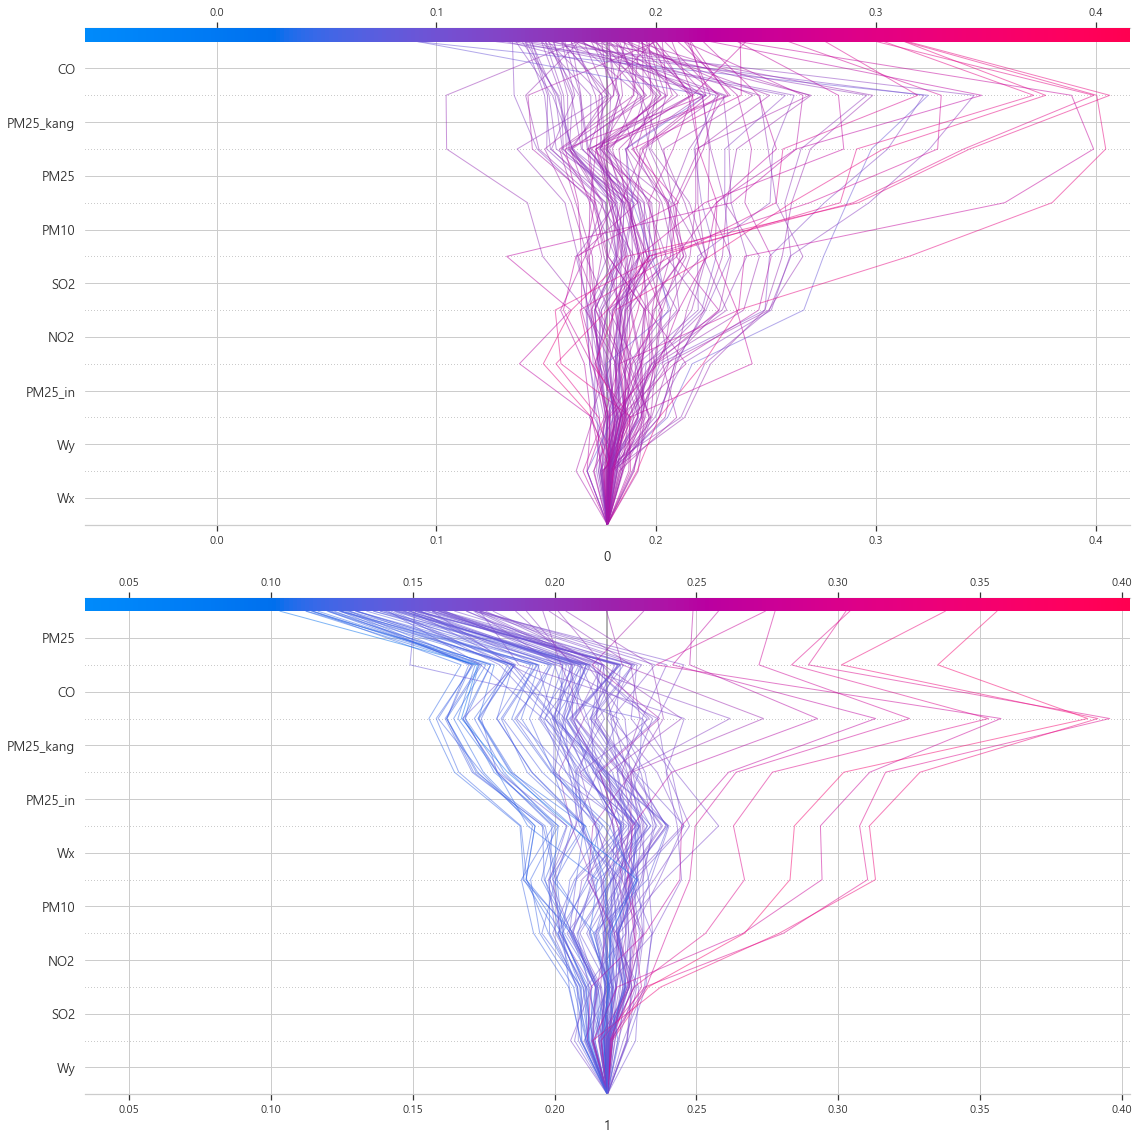

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8*len(shap_values_list)))
gs = fig.add_gridspec(len(shap_values_list), 1)

for i in range(len(shap_values_list)):
    all_df = pd.DataFrame(shap_values_list[i], columns=Features).values
    ax = fig.add_subplot(gs[i, 0])
    #all_df = all_df.reshape((24,int(all_df.shape[0]/24/24),24,len(Features)))

    #all_df= all_df.reshape((all_df.shape[0]*all_df.shape[1],all_df.shape[2]))
    shap.decision_plot(expected_value_list[i], all_df, all_df, feature_names=Features, ignore_warnings=True,auto_size_plot=False,show=False,alpha=0.5)
    ax.set_xlabel(str(i))

plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_decision.png')
plt.show()

In [43]:
C_train = pd.DataFrame(G_TRAIN_X[0].reshape((G_TRAIN_X[0].shape[0],len(Features))),columns=Features).copy()
test = pd.cut(C_train['PM25'].to_list(), 9, retbins=True)
test

([(-1.128, -0.456], (-1.128, -0.456], (-1.128, -0.456], (-1.128, -0.456], (-1.128, -0.456], ..., (-1.128, -0.456], (-1.128, -0.456], (-0.456, 0.216], (-0.456, 0.216], (-0.456, 0.216]]
 Length: 5111
 Categories (9, interval[float64]): [(-1.806, -1.128] < (-1.128, -0.456] < (-0.456, 0.216] < (0.216, 0.889] ... (1.561, 2.233] < (2.233, 2.905] < (2.905, 3.577] < (3.577, 4.249]],
 array([-1.80579732, -1.12767963, -0.45561057,  0.21645849,  0.88852756,
         1.56059662,  2.23266568,  2.90473474,  3.57680381,  4.24887287]))

In [50]:
COLORS = ['#5567ED', '#ED6D73', '#CE6EEB', '#EDC43E', '#4AED72']
reversed(COLORS)
def renderICE(_Model,_X_DATA,check_col, C_list, ax):
    
    for _M in range(len(_Model)):
        
        C_train = pd.DataFrame(_X_DATA[_M].reshape((_X_DATA[_M].shape[0],len(Features))),columns=Features).copy()
        ICE_d = pd.DataFrame(np.empty((_X_DATA[_M].shape[0], len(C_list))), columns = C_list)
        for C in C_list:
            C_train[Features[check_col]] = C
            values = C_train.values
            values = values.reshape((int(C_train.shape[0]),1,len(Features)))
        
            y_hat = _Model[_M].predict(values)
            #y_hat = y_hat.mean(axis=1)
            
            y_hat = y_hat.flatten()
        
            ICE_d[C] = list(y_hat)
            
        for i in range(_X_DATA[_M].shape[0]):
        #for i in range(_X_DATA[_M].shape[0]):
            ax.plot(ICE_d.T.index, ICE_d.T[i], color = COLORS[_M], linewidth = 0.2 , alpha=0.3)
        ND = np.array(ICE_d)
    
        ND = np.average(ND,axis=0)
        ax.plot(ICE_d.T.index, ND, color = 'black', linewidth = 3.0)
        ax.plot(ICE_d.T.index, ND, color = COLORS[_M], linewidth = 2.0)
        print(ICE_d.size)
        ICE_d.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_'+str(_M)+'_ICE_'+str(check_col)+'.csv')

    print('ICE값 저장')
    ax.set_title(Features[check_col])

51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장
51110
89040
ICE값 저장


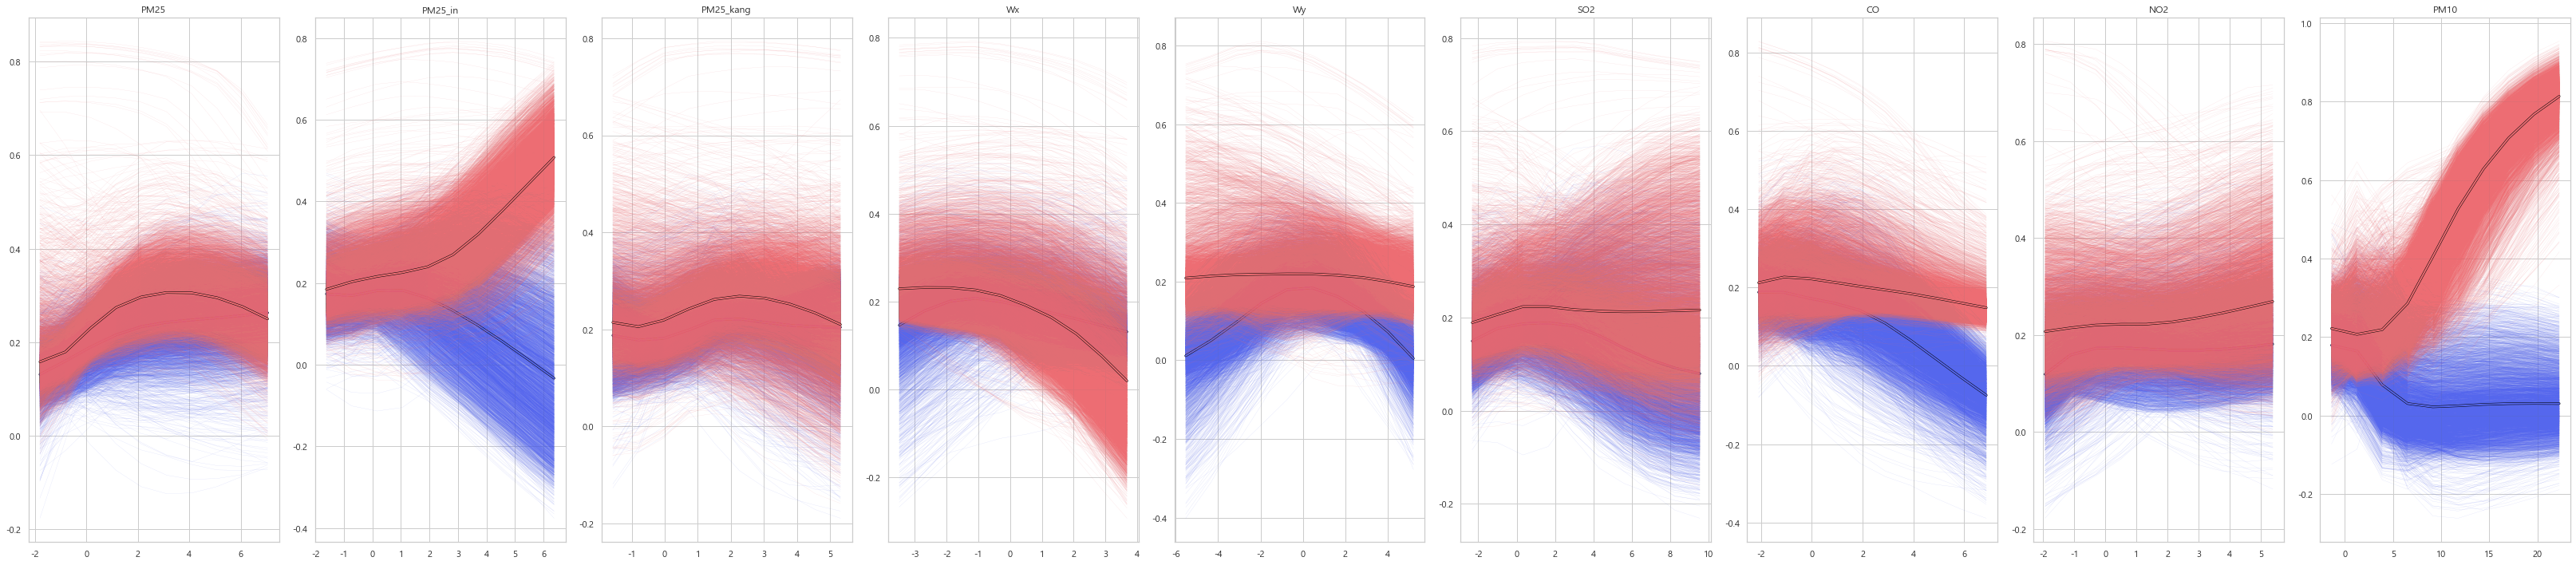

In [51]:
import json
fig = plt.figure(figsize=(5*len(Features), 10))
#C_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#C_list = [0,1.0]
TS = pd.DataFrame(ALL_TRAIN_X.reshape((ALL_TRAIN_X.shape[0],len(Features))), columns=Features)

for i in range(len(Features)):
    renderICE(ENS_MODELS,G_TRAIN_X, i, pd.cut(TS[Features[i]].to_list(), 9, retbins=True)[-1], fig.add_subplot(1, len(Features), i+1))
plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_ICE.png')
plt.show()

In [57]:
COLORS = ['#5567ED', '#ED6D73', '#CE6EEB', '#EDC43E', '#4AED72']
reversed(COLORS)
def renderICE_DE(_Model,_X_DATA,check_col, C_list, ax):
    ICE_d = pd.DataFrame(np.empty((_X_DATA.shape[0], len(C_list))), columns = C_list)
    
    for C in C_list:
        C_train = pd.DataFrame(_X_DATA.reshape((_X_DATA.shape[0],len(Features))),columns=Features).copy()
        
        C_train[Features[check_col]] = C
        values = C_train.values
        values = values.reshape((int(C_train.shape[0]),1,len(Features)))
        
        y_hat = _Model.predict(values)
            #y_hat = y_hat.mean(axis=1)
        
        y_hat = y_hat.flatten()
        
        ICE_d[C] = list(y_hat)
            
    for i in range(_X_DATA.shape[0]):
        #for i in range(_X_DATA[_M].shape[0]):
            ax.plot(ICE_d.T.index, ICE_d.T[i], color = COLORS[0], linewidth = 0.2 , alpha=0.3)
            
    ND = np.array(ICE_d)
    ND = np.average(ND,axis=0)
    ax.plot(ICE_d.T.index, ND, color = 'black', linewidth = 3.0)
    ax.plot(ICE_d.T.index, ND, color = COLORS[0], linewidth = 2.0)
    
    print(ICE_d.size)
        #ICE_d.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_'+str(_M)+'_ICE_'+str(check_col)+'.csv')

    #print('ICE값 저장')
    ax.set_title(Features[check_col])

In [58]:
ALL_TRAIN_X.shape

(14016, 1, 9)

140160
140160
140160
140160
140160
140160
140160
140160
140160


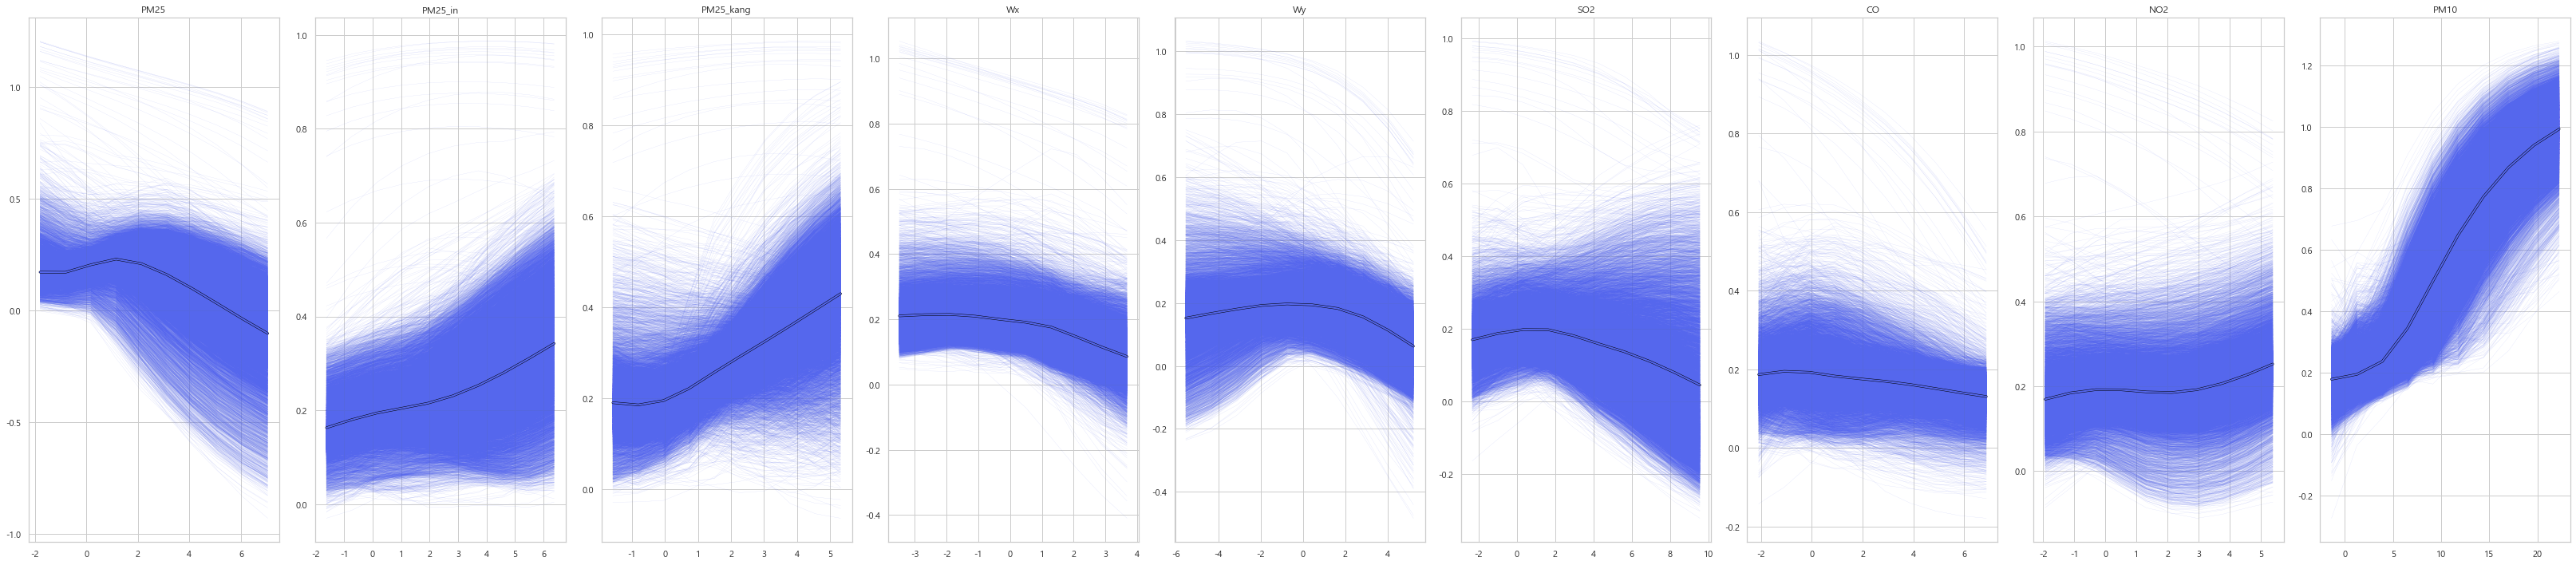

In [59]:
import json
fig = plt.figure(figsize=(5*len(Features), 10))

TS = pd.DataFrame(ALL_TRAIN_X.reshape((ALL_TRAIN_X.shape[0],len(Features))), columns=Features)

    
for i in range(len(Features)):
    renderICE_DE(ALL_MODEL,ALL_TRAIN_X, i, pd.cut(TS[Features[i]].to_list(), 9, retbins=True)[-1], fig.add_subplot(1, len(Features), i+1))
    
plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_DE_ICE.png')
plt.show()